# Example-based Explanation

## Imports

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from naf.forests import ForestKind, TaskType
from naf.naf_model import NeuralAttentionForest, NAFParams
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from time import time
from matplotlib import pyplot as plt


import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import torch

## Utils

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# cmap = truncate_colormap(cm.jet, minval=0.0, maxval=0.5)
# cmap = truncate_colormap(cm.plasma, minval=0.0, maxval=0.75)
cmap = cm.plasma


def plot_decision_boundary(all_X, predict_method, grid_shape=(40, 40), c=1.0, ax=None,
                           use_contours: bool = False, need_colorbar: bool = True, **kwargs):
    grid_x = np.stack(np.meshgrid(
        np.linspace(all_X[:, 0].min() * c, all_X[:, 0].max() * c, grid_shape[0]),
        np.linspace(all_X[:, 1].min() * c, all_X[:, 1].max() * c, grid_shape[1])
    ), axis=-1).reshape((-1, 2))

    preds_on_grid = predict_method(grid_x)
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = None
    if not use_contours:
        p = ax.pcolormesh(
            grid_x[:, 0].reshape(grid_shape),
            grid_x[:, 1].reshape(grid_shape),
            preds_on_grid.reshape(grid_shape),
            **kwargs
        )
    else:
        p = ax.contourf(
            grid_x[:, 0].reshape(grid_shape),
            grid_x[:, 1].reshape(grid_shape),
            preds_on_grid.reshape(grid_shape),
            **kwargs
        )
    if need_colorbar:
        plt.colorbar(p, ax=ax)
    return fig, ax, p


## Data preparation

It is important to have the input data correctly scaled.

In [3]:
X, y = make_moons(100, noise=0.1, random_state=12345)
X = StandardScaler(copy=False).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=12345)

pt = X_test[y_test == 1][0:1]

## Model settings

Parameters:

- `n_epochs` – number of epochs for neural network training;
- `lr` – neural network learning rate;
- `lam` – reconstruction loss weight (typically $0 \le \lambda \le 1$, $0$ means no reconstruction loss);
- `target_loss_weight` – target estimation loss weight (typically is $1$);
- `hidden_size` – size of each neural network layer;
- `n_layers` – number of neural network layers;
- `forest` – parameters of an underlying forest.

In [4]:
params = NAFParams(
    kind=ForestKind.EXTRA,
    task=TaskType.REGRESSION,
    mode='end_to_end',
    n_epochs=100,
    lr=0.01,
    lam=1.0,
    target_loss_weight=1.0,
    hidden_size=16,
    n_layers=1,
    forest=dict(
        n_estimators=100,
        min_samples_leaf=1
    ),
    random_state=12345
)
model = NeuralAttentionForest(params)

## Neural network training & Explanation

Train score original: 1.0 test score original: 0.7611728837876615
Train score before optimization: 1.0 test score: 0.8931877767423553
Optimization duration: 0.17745685577392578
Train score after optimization: 1.0 test score: 0.9367449800240638
Current point: array([[-0.64039909,  0.38908658]])
Top-3 explanation examples:
    Point  15: X = array([-0.31215962,  0.65098406]); y = 1
    Point  11: X = array([-0.74995187, -0.34459718]); y = 1
    Point   0: X = array([-0.42999111,  0.13013615]); y = 1


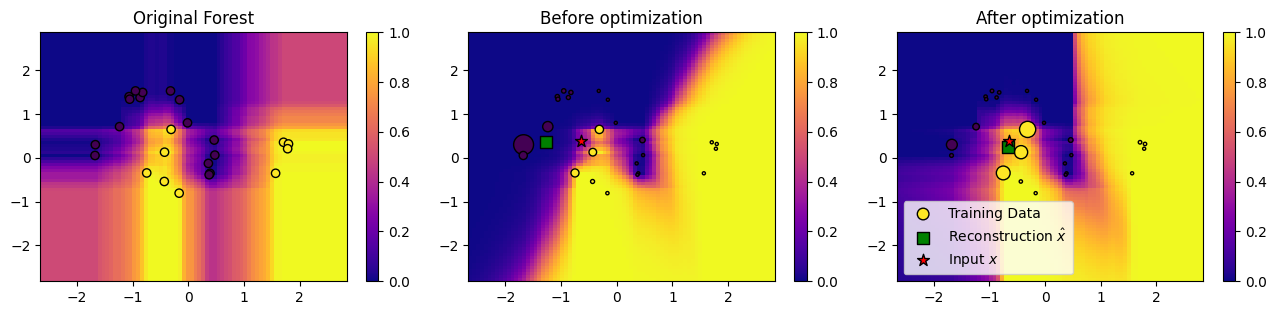

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3.25))
db_kwargs = dict(
    c=1.5,
    cmap=cmap,
    use_contours=False,
    grid_shape=(80, 80),
    # shading='gouraud',
    # levels=15
)
pt_kwargs = dict(marker='*', c='r', s=80, edgecolor='k', label='Input $x$')
recon_kwargs = dict(marker='s', c='g', s=80, edgecolor='k', label='Reconstruction $\\hat{x}$')


model.fit(X_train, y_train)
print(
    'Train score original:',
    r2_score(y_train, model.predict_original(X_train)),
    'test score original:',
    r2_score(y_test, model.predict_original(X_test)),
)
plot_decision_boundary(X, model.predict_original, ax=ax[0], need_colorbar=True, **db_kwargs)
ax[0].scatter(*X_train.T, c=y_train, edgecolor='k')
ax[0].set_title('Original Forest')

print(
    'Train score before optimization:',
    r2_score(y_train, model.predict(X_train)),
    'test score:',
    r2_score(y_test, model.predict(X_test)),
)
before_pred, before_recon, before_alphas, before_betas = model.predict(pt, need_attention_weights=True)
before_point_weights = np.einsum('nsb,nb->ns', before_alphas, before_betas)

plot_decision_boundary(X, model.predict, ax=ax[1], need_colorbar=True, **db_kwargs)
ax[1].scatter(*X_train.T, c=y_train, edgecolor='k', s=5 + before_point_weights[0] * 400)
ax[1].scatter(*before_recon[0], **recon_kwargs)
ax[1].scatter(*pt[0], **pt_kwargs)
ax[1].set_title('Before optimization')

start_time = time()
model.optimize_weights(X_train, y_train)
end_time = time()
print('Optimization duration:', end_time - start_time)
print(
    'Train score after optimization:',
    r2_score(y_train, model.predict(X_train)),
    'test score:',
    r2_score(y_test, model.predict(X_test)),
)

plot_decision_boundary(X, model.predict, ax=ax[2], **db_kwargs)
# plt.scatter(*X.T, c=y)
pred, recon, alphas, betas = model.predict(pt, need_attention_weights=True)
point_weights = np.einsum('nsb,nb->ns', alphas, betas)
ax[2].scatter(*X_train.T, c=y_train, edgecolor='k', s=5 + point_weights[0] * 400, label='Training Data')
ax[2].scatter(*recon[0], **recon_kwargs)
ax[2].scatter(*pt[0], **pt_kwargs)
ax[2].set_title('After optimization')
plt.legend()
plt.tight_layout()

k = 3
weights_sorter = np.argsort(-point_weights.ravel())
print(f'Current point: {pt!r}')
print(f'Top-{k} explanation examples:')
for i in range(k):
    idx = weights_sorter[i]
    print(f'    Point {idx:3d}: X = {model.training_xs[idx]!r}; y = {model.training_y[idx]!r}')